# Setup, Training, and Evaluating CNNs for Tree Genera Classification

The following Jupyter Notebook includes code to setup and train a convolutional neural network with Python and Pytorch.

Version: April 2024



In [22]:

# Imports for Pytorch
import torch # version 2.1.2
import torchvision # version 0.16.2
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import v2
import torch.nn as nn # contains base class for all neural network modules
import torch.nn.functional as F #https://pytorch.org/docs/stable/nn.functional.html contains common functions for training NNs (convolutions, losses, etc..)
from sklearn.metrics import classification_report
import torch.cuda.amp as amp



# Image processing and display
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Other Imports
import os
import shutil
import random
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import time
from imageio import imread



## Setup new testing and training datasets, save their metadata as csvs, and print number of images to console

### Functions to create new testing and training datasets, export metadata, and print number of images to the console

In [23]:
# Functions to create datasets for training and testing, export metadata to csv, and print directory information
# Function to export metadata to csv
def process_existing_files(root_directory, csv_path, export_csv=False):
    """
    Process existing files in the root directory and write to csv.

    Parameters:
    root_directory (str): The path to the root directory containing images of tree genera.

    Returns:
    Print statement with the file path to the csv.
    """
    existing_files = {}

    # Get the list of genus names from the root directory
    genera = os.listdir(root_directory)

    for genus in genera:
        genus_dir = os.path.join(root_directory, genus)
        genus_files = os.listdir(genus_dir)
        existing_files[genus] = genus_files

    # Create a dataframe from the dictionary
    df = pd.DataFrame(existing_files.items(), columns=['genus', 'files'])
    df = df.explode('files')

    # Add additional column for data source
    if "inat" in root_directory.lower():
        df['data_source'] = "iNaturalist"
    else:
        df['data_source'] = "Autoarborist"
    
    if export_csv:
        # Write to csv
        csv_filepath = os.path.join(csv_path, os.path.basename(root_directory) + ".csv")
        df.to_csv(csv_filepath, index=False)
        print(f"Existing files for {root_directory} written to csv.")
    else:
        return df
    
# Function to print directory information
def print_directory_info(root_directory):
    """
    Print the number of files in each directory in the root directory.

    Parameters:
    root_directory (str): The path to the root directory containing images of tree genera.

    Returns:
    Print statement with the number of files in each directory.
    """
    for genus_folder in os.listdir(root_directory):
        genus_path = os.path.join(root_directory, genus_folder)
        
        # Check if it's a directory
        if os.path.isdir(genus_path):
            # Count the number of files in the directory
            num_files = len([f for f in os.listdir(genus_path) if os.path.isfile(os.path.join(genus_path, f))])
            
            print(f"Directory: {genus_folder}, Number of Files: {num_files}")
    return None

# Function to create datasets for training and testing: Autoarborist or iNaturalist
def create_datasets (training_ratio, max_training_images_og, max_testing_images_og, selected_genera, source_root, testing_destination_root, 
                     training_destination_root, existing_training_root, existing_testing_root, append, csv_path):
    """
    Create training and testing datasets for selected genera from any source image dataset.
    
    Parameters:
    training_ratio (float): The ratio of training images to total images.
    max_training_images_og (int): The maximum number of training images to select.
    max_testing_images_og (int): The maximum number of testing images to select.
    selected_genera (list): The list of selected genera to include in the training and testing datasets.
    source_root (str): The path to the source directory containing all available images of tree genera from Autoarborist.
    testing_destination_root (str): The path to the destination directory for images of tree genera as testing data.
    training_destination_root (str): The path to the destination directory for images of tree genera as training data.
    existing_training_root (str): The path to the existing directory containing images of tree genera as training data used in previous experiments.
    existing_testing_root (str): The path to the existing directory containing images of tree genera as testing data used in previous experiments.
    append (bool): A logical statement to append new images to existing training and testing data.
    
    Returns:
    None
    """
    # Iterate through the source directory
    for genus_folder in os.listdir(source_root):
        max_training_images = max_training_images_og
        max_testing_images = max_testing_images_og
        # Keep track of starting time
        start_time = time.time()
        genus_path = os.path.join(source_root, genus_folder) # Get path to images for each genera
    
        # List all images in the current genus folder. Some images are .jpg and .jpeg format.
        # If "inat" is found anywhere in the genus folder name, then the images are in the root folder.
        if "inat" in genus_path.lower():
            images = [image for image in os.listdir(genus_path) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]
        else:
            images = [image for image in os.listdir(os.path.join(genus_path, 'images')) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Only select genera with >100 images.
        if len(images) > 100:
            # Check if it's a directory and if it's in the selected genera list
            if os.path.isdir(genus_path) and genus_folder in selected_genera:
                # Create destination folders for the training and testing data for the current genus
                training_destination_genus_path = os.path.join(training_destination_root, genus_folder)
                testing_destination_genus_path = os.path.join(testing_destination_root, genus_folder)
                os.makedirs(training_destination_genus_path, exist_ok=True)
                os.makedirs(testing_destination_genus_path, exist_ok=True)
                # Append new images to existing training and testing data
                if append:
                    print(f"Copying existing images for {genus_folder} to new training and testing folders.")
                    existing_training_genus_path = os.path.join(existing_training_root, genus_folder)
                    existing_testing_genus_path = os.path.join(existing_testing_root, genus_folder)

                    # Copy existing training images to the new training destination folder
                    for image in os.listdir(existing_training_genus_path):
                        source_image_path = os.path.join(existing_training_genus_path, image)
                        destination_image_path = os.path.join(training_destination_genus_path, image)
                        _= shutil.copy2(source_image_path, destination_image_path)

                    # Copy existing testing images to the new testing destination folder
                    for image in os.listdir(existing_testing_genus_path):
                        source_image_path = os.path.join(existing_testing_genus_path, image)
                        destination_image_path = os.path.join(testing_destination_genus_path, image)
                        _= shutil.copy2(source_image_path, destination_image_path)

                    # Update the max_training_images and max_testing_images
                    max_training_images = max_training_images - len(os.listdir(existing_training_genus_path))
                    max_testing_images = max_testing_images - len(os.listdir(existing_testing_genus_path))
                    print(f"Updated max_training_images: {max_training_images}, max_testing_images: {max_testing_images}")

                    # Update images to exclude the existing training and testing images
                    print(f"Total number of available images: {len(images)} for {genus_folder}...")
                    existing_training_images = set(os.listdir(existing_training_genus_path))
                    existing_testing_images = set(os.listdir(existing_testing_genus_path))
                    images = [image for image in images if image not in existing_training_images and image not in existing_testing_images]
                    print(f"Total number of images after excluding existing training and testing images: {len(images)} for {genus_folder}...")

                # Randomly select a number of images from the folder here: (900 training + 100 testing).
                if len(images) > max_training_images + max_testing_images:
                    images = random.sample(images, max_training_images + max_testing_images) # file paths for images

                # Randomly divide images into training and testing sets
                num_total_images = len(images)
                num_training_images_to_copy = min(int(num_total_images * training_ratio), max_training_images)

                # Randomly shuffle the images before moving
                random.shuffle(images)

                # Split images into training and testing sets
                training_images = images[:num_training_images_to_copy]
                testing_images = images[num_training_images_to_copy:]
            
                # Copy training images to the training destination folder
                print(f"Copying new images for {genus_folder} to new training and testing folders.")
                for image in training_images:
                    if "inat" in genus_path.lower():
                        source_image_path = os.path.join(genus_path, image)
                    else:
                        source_image_path = os.path.join(genus_path, 'images', image)
                    destination_image_path = os.path.join(training_destination_genus_path, image)
                    _= shutil.copy2(source_image_path, destination_image_path)

                # Copy testing images to the testing destination folder
                for image in testing_images:
                    if "inat" in genus_path.lower():
                        source_image_path = os.path.join(genus_path, image)
                    else:
                        source_image_path = os.path.join(genus_path, 'images', image)
                    destination_image_path = os.path.join(testing_destination_genus_path, image)
                    _= shutil.copy2(source_image_path, destination_image_path)
                # Keep track of ending time
                end_time = time.time()
                # Report time take in minutes
                total_time = (end_time - start_time) / 60
                print(f"Images copied successfully for {genus_folder}. Time taken: {total_time} minutes.")
    print(f"All images copied successfully for: {selected_genera}.")
    process_existing_files(training_destination_root, csv_path, export_csv=True)
    return None



# Function to combine existing training and testing data

def combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root):
    """
    Combine the training datasets from Autoarborist and iNaturalist into a single testing or training dataset.
    Combine the testing datasets from Autoarborist and iNaturalist into a single testing or training dataset.
    Combine the metadata from Autoarborist and iNaturalist into a single metadata file.

    Parameters:
    autoarborist_dataset_root (str): The path to the Autoarborist testing or training dataset.
    inaturalist_dataset_root (str): The path to the iNaturalist testing or training dataset.
    combined_dataset_root (str): The path to the combined testing or training dataset.

    Returns:
    None
    """
    # Create the combined training dataset directory
    os.makedirs(combined_dataset_root, exist_ok=True)

    # Copy the Autoarborist dataset to the combined dataset
    for genus_folder in os.listdir(autoarborist_dataset_root):
        genus_path = os.path.join(autoarborist_dataset_root, genus_folder)
        destination_genus_path = os.path.join(combined_dataset_root, genus_folder)
        os.makedirs(destination_genus_path, exist_ok=True)
        print(f"Copying Autoarborist images for {genus_folder} to the combined dataset.")

        for image in os.listdir(genus_path):
            source_image_path = os.path.join(genus_path, image)
            destination_image_path = os.path.join(destination_genus_path, image)
            _= shutil.copy2(source_image_path, destination_image_path)
        
    
    # Copy the iNaturalist dataset to the training dataset
    for genus_folder in os.listdir(inaturalist_dataset_root):
        genus_path = os.path.join(inaturalist_dataset_root, genus_folder)
        destination_genus_path = os.path.join(combined_dataset_root, genus_folder)
        os.makedirs(destination_genus_path, exist_ok=True)
        print(f"Copying iNaturalist images for {genus_folder} to the combined dataset.")

        for image in os.listdir(genus_path):
            source_image_path = os.path.join(genus_path, image)
            destination_image_path = os.path.join(destination_genus_path, image)
            _= shutil.copy2(source_image_path, destination_image_path)

    print(f"Combined dataset created successfully.")

    # Combine the autoarborist_root, inaturalist_root, and combined_root metadata
    roots = [autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root]
    updated_roots = [os.path.join(os.path.join(root.rsplit('\\', 1)[0], os.path.basename(root) + ".csv")) for root in roots]
    
    # Pull in the existing metadata for autoarborist
    autoarborist_metadata = pd.read_csv(updated_roots[0])
    # Pull in the existing metadata for inaturalist
    inaturalist_metadata = pd.read_csv(updated_roots[1])
    # Combine the metadata
    combined_metadata = pd.concat([autoarborist_metadata, inaturalist_metadata], ignore_index=True)
    # Write to csv
    combined_metadata.to_csv(updated_roots[2], index=False)
    print(f"Combined metadata written to csv.")
    return None

# Constants
selected_genera = ['acer','ailanthus','betula','citrus','fraxinus','gleditsia','juglans','juniperus', 'magnolia','phoenix','picea',
                   'pinus','prunus','pseudotsuga','pyrus','quercus','rhus','sequoia','taxodium', 'thuja','tilia','ulmus','washingtonia']
training_ratio = 0.9 # ratio of training images to total images
max_training_images_og = 1187 # maximum number of training images to select
max_testing_images_og = 132 # maximum number of testing images to select


### Autoarborist: Source, append, and create new testing and training datasets

In [ ]:
# Source: contains all available street view images of tree genera from Autoarborist
source_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\autoarborist_original_data\autoarborist_original_jpegs\jpegs_streetlevel_genus_idx_label"

# Target: location for images of tree genera as training data 
training_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\training_dataset_small_apr624"

# Target: location for images of tree genera as testing data 
testing_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\testing_dataset_small_apr624"

# Existing Target: location for existing images of tree genera as training data used in previous experiments
existing_training_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\training_dataset_small_march624"

# Existing Target: location for existing images of tree genera as testing data used in previous experiments
existing_testing_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\testing_dataset_small_march624"

# Append: logical statement to append new images to existing training and testing data
append = True

# CSV path: location to save the CSV file containing the training and testing data
csv_path = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist"

# Select all genera
#selected_genera = os.listdir(source_root)
# create_datasets(training_ratio, max_training_images_og, max_testing_images_og, selected_genera, source_root, testing_destination_root,
#                     training_destination_root, existing_training_root, existing_testing_root, append)

# Export metadata for existing training and testing data
process_existing_files(training_destination_root, csv_path, export_csv=True)
process_existing_files(testing_destination_root, csv_path, export_csv=True)

### Autoarborist: Print the number of images for the new training and testing directories

In [ ]:
# Print information for the training directory
print("Training Directory Information:")
print_directory_info(training_destination_root)

# Print information for the testing directory
print("/nTesting Directory Information:")
print_directory_info(testing_destination_root)

### iNaturalist: Source, append, and create new testing and training datasets for images

In [ ]:
# Set the paths for Autoarborist training and testing data

# Source: contains all available street view images of tree genera from iNaturalist
source_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inat\images\original_10k"

# Target: location for images of tree genera as training data 
training_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\training_dataset_small_apr624"

# Target: location for images of tree genera as testing data 
testing_destination_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\testing_dataset_small_apr624"

# Existing Target: location for existing images of tree genera as training data used in previous experiments
existing_training_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\training_dataset_small_apr624"

# Existing Target: location for existing images of tree genera as testing data used in previous experiments
existing_testing_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\testing_dataset_small_apr624"

# Append: logical statement to append new images to existing training and testing data
append = True

# CSV path: location to save the CSV file containing the training and testing data
csv_path = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist"

# Select all genera
selected_genera = os.listdir(source_root)
create_datasets(training_ratio, max_training_images_og, max_testing_images_og, selected_genera, source_root, testing_destination_root,
                    training_destination_root, existing_training_root, existing_testing_root, append,csv_path)

### iNaturalist: Print the number of images for the new training and testing directories

In [ ]:
# Print information for the training directory
print("Training Directory Information:")
print_directory_info(training_destination_root)

# Print information for the testing directory
print("/nTesting Directory Information:")
print_directory_info(testing_destination_root)

### Autoarborist + iNaturalist: Combine Training and Testing Records

In [ ]:
# Combine the training datasets

# Set the paths for the combined training dataset
autoarborist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\training_dataset_small_apr624"
inaturalist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\training_dataset_small_apr624"
combined_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\aa_inat_combined\training_dataset_small_apr624"

# Combine the training datasets
combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root)

# Set the paths for the combined training dataset
autoarborist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\autoarborist\testing_dataset_small_apr624"
inaturalist_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\inaturalist\testing_dataset_small_apr624"
combined_dataset_root = r"Z:\auto_arborist_cvpr2022_v0.15\data\tree_classification\aa_inat_combined\testing_dataset_small_apr624"

# Combine the training datasets
combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root)

### Autoarborist + iNaturalist: Print the number of images for the new training and testing directories

### iNaturalist (CURATED): Source, append, and create new testing and training datasets for images

In [31]:
# # Set the paths for iNaturalist training and testing data
# Setup file paths for the softmax csvs
acer_path = r"Z:\auto_arborist_cvpr2022_v0.15\analyses\tree_classification\pytorch_cnn_classifier_autoarborist_inaturalist_experiments_march2024\autoarborist_predicted_on_inat_acer_303k_images_probability_scores_apr2924.csv"
aila_path = r"Z:\auto_arborist_cvpr2022_v0.15\analyses\tree_classification\pytorch_cnn_classifier_autoarborist_inaturalist_experiments_march2024\autoarborist_predicted_on_inat_ailanthus_48k_image_probability_scores_apr2924.csv"
quer_path = r"Z:\auto_arborist_cvpr2022_v0.15\analyses\tree_classification\pytorch_cnn_classifier_autoarborist_inaturalist_experiments_march2024\autoarborist_predicted_on_inat_quercus_286k_image_probability_scores_apr2924.csv"
inat_10k_path = r"Z:\auto_arborist_cvpr2022_v0.15\analyses\tree_classification\pytorch_cnn_classifier_autoarborist_inaturalist_experiments_march2024\autoarborist_predicted_on_inat_10kimgs_genus_image_probability_scores_march2024.csv"


# Pull in softmax csvs file for iNaturalist
acer_full = pd.read_csv(acer_path)
aila_full = pd.read_csv(aila_path)
quer_full = pd.read_csv(quer_path)
inat_10k = pd.read_csv(inat_10k_path)


# Drop "acer", "ailanthus", "quercus" from the inat_10k dataframe
inat_10k = inat_10k[~inat_10k['Genus'].isin(["acer", "ailanthus", "quercus"])]

# Add base directory to the softmax csvs to keep track when combining

# Add a new column 'orig_csv_name' contains the original csv file name
acer_full['orig_csv_name'] = os.path.basename(acer_path)
aila_full['orig_csv_name'] = os.path.basename(aila_path)
quer_full['orig_csv_name'] = os.path.basename(quer_path)
inat_10k['orig_csv_name'] = os.path.basename(inat_10k_path)

# Add a new column 'source_root' that contains the source root directory
source_root_full = r"D:\inat\images\original_full"
source_root_10k = r"D:\inat\images\original_10k"

# Add a new column 'source_filepath' that contains the joined 'source_root_full', 'Genus', and 'Image' column values
acer_full['source_filepath'] = acer_full.apply(lambda row: os.path.join(source_root_full, row['Genus'], row['Image']), axis=1)
aila_full['source_filepath'] = aila_full.apply(lambda row: os.path.join(source_root_full, row['Genus'], row['Image']), axis=1)
quer_full['source_filepath'] = quer_full.apply(lambda row: os.path.join(source_root_full, row['Genus'], row['Image']), axis=1)
inat_10k['source_filepath'] = inat_10k.apply(lambda row: os.path.join(source_root_10k, row['Genus'], row['Image']), axis=1)

# Print head of the softmax csvs
acer_full.head()
 
# Merge the softmax csvs
combined_softmax = pd.concat([acer_full, aila_full, quer_full, inat_10k], ignore_index=True)

# Write the combined softmax csv to a file
combined_softmax.to_csv(r"Z:\auto_arborist_cvpr2022_v0.15\analyses\tree_classification\pytorch_cnn_classifier_autoarborist_inaturalist_experiments_march2024\combined_softmax_5724.csv", index=False)

# Pull out the top 1000 images using the Softmax Probability column and group by Genus
top_1000_images = combined_softmax.groupby('Genus').apply(lambda x: x.nlargest(1000, 'Softmax Probability')).reset_index(drop=True)

# Write the top 1000 images to a file
top_1000_images.to_csv(r"Z:\auto_arborist_cvpr2022_v0.15\analyses\tree_classification\pytorch_cnn_classifier_autoarborist_inaturalist_experiments_march2024\top_1000_images_5724.csv", index=False)

# Compute 50th, 75th, 90th percentile of the Softmax Probability column by Genus for the top 1000 images and store in a new dataframe
top_1000_images_stats = top_1000_images.groupby('Genus')['Softmax Probability'].agg(['mean', 'median', 'max', 'min']).reset_index()
# Compute 25th, 50th, 75th, 90th percentile of the Softmax Probability column by Genus for the top 1000 images and store in a new dataframe
percentiles = [25, 50, 75, 90]

for percentile in percentiles:
    top_1000_images_stats[f'{percentile}th percentile'] = top_1000_images.groupby('Genus')['Softmax Probability'].apply(lambda x: np.percentile(x, percentile)).reset_index(drop=True)

# Write the top 1000 images stats to a file
top_1000_images_stats.to_csv(r"Z:\auto_arborist_cvpr2022_v0.15\analyses\tree_classification\pytorch_cnn_classifier_autoarborist_inaturalist_experiments_march2024\top_1000_images_stats_5724.csv", index=False)

# Filter the top_1000_images by Genus, then randomly select 900 images for training and 100 images for testing, then copy the images to the training and testing directories

training_destination_root = r"D:\blaginh\tree_classification\inaturalist\training_data_top1000_may724_curated"
testing_destination_root = r"D:\blaginh\tree_classification\inaturalist\testing_data_top1000_may724_curated"

# Create the training and testing directories
os.makedirs(training_destination_root, exist_ok=True)
os.makedirs(testing_destination_root, exist_ok=True)

# Iterate through the top_1000_images dataframe

for genus in top_1000_images['Genus'].unique():
    genus_images = top_1000_images[top_1000_images['Genus'] == genus]
    genus_training_images = genus_images.sample(n=900)
    genus_testing_images = genus_images.drop(genus_training_images.index)
    
    # Create the genus training and testing directories
    genus_training_destination = os.path.join(training_destination_root, genus)
    genus_testing_destination = os.path.join(testing_destination_root, genus)
    
    os.makedirs(genus_training_destination, exist_ok=True)
    os.makedirs(genus_testing_destination, exist_ok=True)
    
    # Copy the training images
    for index, row in genus_training_images.iterrows():
        source_image_path = os.path.normpath(row['source_filepath'])
        destination_image_path = os.path.join(genus_training_destination, row['Image'])
        _= shutil.copy2(source_image_path, destination_image_path)
    
    # Copy the testing images
    for index, row in genus_testing_images.iterrows():
        source_image_path = os.path.normpath(row['source_filepath'])
        destination_image_path = os.path.join(genus_testing_destination, row['Image'])
        _= shutil.copy2(source_image_path, destination_image_path)
    print(f"Images copied successfully for {genus}.")
training_destination_root = r"D:\blaginh\tree_classification\inaturalist\training_data_top1000_may724_curated"
testing_destination_root = r"D:\blaginh\tree_classification\inaturalist\testing_data_top1000_may724_curated"
csv_path = r"D:\blaginh\tree_classification\inaturalist"
process_existing_files(training_destination_root, csv_path, export_csv=True)
process_existing_files(testing_destination_root, csv_path, export_csv=True)

,Genus,Image,Softmax Probability,orig_csv_name,source_filepath
0,acer,53753889.jpg,0.946010,autoarborist_predicted_on_inat_acer_303k_image...,D:\inat\images\original_full\acer\53753889.jpg
1,acer,299592441.jpg,0.909637,autoarborist_predicted_on_inat_acer_303k_image...,D:\inat\images\original_full\acer\299592441.jpg
2,acer,87897345.jpg,0.903870,autoarborist_predicted_on_inat_acer_303k_image...,D:\inat\images\original_full\acer\87897345.jpg
3,acer,110044395.jpeg,0.899195,autoarborist_predicted_on_inat_acer_303k_image...,D:\inat\images\original_full\acer\110044395.jpeg
4,acer,97287883.jpg,0.899188,autoarborist_predicted_on_inat_acer_303k_image...,D:\inat\images\original_full\acer\97287883.jpg


C:\Users\talake2\AppData\Local\Temp\ipykernel_34420\1771539121.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_1000_images = combined_softmax.groupby('Genus').apply(lambda x: x.nlargest(1000, 'Softmax Probability')).reset_index(drop=True)


Images copied successfully for acer.
Images copied successfully for ailanthus.
Images copied successfully for betula.
Images copied successfully for citrus.
Images copied successfully for cupaniopsis.
Images copied successfully for erythrina.
Images copied successfully for fraxinus.
Images copied successfully for gleditsia.
Images copied successfully for juglans_nigra.
Images copied successfully for juniperus.
Images copied successfully for magnolia.
Images copied successfully for phoenix.
Images copied successfully for picea.
Images copied successfully for pinus.
Images copied successfully for prunus.
Images copied successfully for pseudotsuga.
Images copied successfully for pyrus.
Images copied successfully for quercus.
Images copied successfully for rhus.
Images copied successfully for sequoia.
Images copied successfully for taxodium.
Images copied successfully for thuja.
Images copied successfully for tilia.
Images copied successfully for ulmus.
Images copied successfully for washi

### iNaturalist (CURATED): Print the number of images for the new training and testing directories

In [33]:
training_destination_root = r"D:\blaginh\tree_classification\inaturalist\training_data_top1000_may724_curated"
testing_destination_root = r"D:\blaginh\tree_classification\inaturalist\testing_data_top1000_may724_curated"

# Specify the current directory name and the new directory name
current_dir_name = 'juglans_nigra'
new_dir_name = 'juglans'

# Full paths for the current and new directory names
current_dir_path = os.path.join(training_destination_root, current_dir_name)
new_dir_path = os.path.join(training_destination_root, new_dir_name)

# Rename the juglans_nigra in training folder
os.rename(current_dir_path, new_dir_path)

# Full paths for the current and new directory names
current_dir_path = os.path.join(testing_destination_root, current_dir_name)
new_dir_path = os.path.join(testing_destination_root, new_dir_name)

# Rename the juglans_nigra in training folder
os.rename(current_dir_path, new_dir_path)

# Print information for the training directory
print("Training Directory Information:")
print_directory_info(training_destination_root)

# Print information for the testing directory
print("/nTesting Directory Information:")
print_directory_info(testing_destination_root)

Training Directory Information:
Directory: acer, Number of Files: 900
Directory: ailanthus, Number of Files: 900
Directory: betula, Number of Files: 900
Directory: citrus, Number of Files: 900
Directory: cupaniopsis, Number of Files: 900
Directory: erythrina, Number of Files: 900
Directory: fraxinus, Number of Files: 900
Directory: gleditsia, Number of Files: 900
Directory: juglans, Number of Files: 900
Directory: juniperus, Number of Files: 900
Directory: magnolia, Number of Files: 900
Directory: phoenix, Number of Files: 900
Directory: picea, Number of Files: 900
Directory: pinus, Number of Files: 900
Directory: prunus, Number of Files: 900
Directory: pseudotsuga, Number of Files: 900
Directory: pyrus, Number of Files: 900
Directory: quercus, Number of Files: 900
Directory: rhus, Number of Files: 900
Directory: sequoia, Number of Files: 900
Directory: taxodium, Number of Files: 900
Directory: thuja, Number of Files: 900
Directory: tilia, Number of Files: 900
Directory: ulmus, Number 

### Autoarborist + iNaturalist (CURATED): Combine Training and Testing Records

In [34]:
# Set the paths for the combined training dataset
autoarborist_dataset_root = r"D:\blaginh\tree_classification\autoarborist\training_dataset_small_march624"
inaturalist_dataset_root = r"D:\blaginh\tree_classification\inaturalist\training_data_top1000_may724_curated"
combined_dataset_root = r"D:\blaginh\tree_classification\aa_inat_combined\training_data_top1000_may724_curated"

# Combine the training datasets
combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root)

# Set the paths for the combined training dataset
autoarborist_dataset_root = r"D:\blaginh\tree_classification\autoarborist\testing_dataset_small_march624"
inaturalist_dataset_root = r"D:\blaginh\tree_classification\inaturalist\testing_data_top1000_may724_curated"
combined_dataset_root = r"D:\blaginh\tree_classification\aa_inat_combined\testing_data_top1000_may724_curated"

# Combine the training datasets
combine_datasets(autoarborist_dataset_root, inaturalist_dataset_root, combined_dataset_root)

Copying Autoarborist images for acer to the combined dataset.
Copying Autoarborist images for ailanthus to the combined dataset.
Copying Autoarborist images for betula to the combined dataset.
Copying Autoarborist images for citrus to the combined dataset.
Copying Autoarborist images for cupaniopsis to the combined dataset.
Copying Autoarborist images for erythrina to the combined dataset.
Copying Autoarborist images for fraxinus to the combined dataset.
Copying Autoarborist images for gleditsia to the combined dataset.
Copying Autoarborist images for juglans to the combined dataset.
Copying Autoarborist images for juniperus to the combined dataset.
Copying Autoarborist images for magnolia to the combined dataset.
Copying Autoarborist images for phoenix to the combined dataset.
Copying Autoarborist images for picea to the combined dataset.
Copying Autoarborist images for pinus to the combined dataset.
Copying Autoarborist images for prunus to the combined dataset.
Copying Autoarborist 

## Setup EfficientNetv2 model to run experiments

In [28]:
# Functions to prepare a Basic Model for Image Classification

class ImageClassificationBase(nn.Module): # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
    # Define a base class with functionality for model training, validation, and evaluation per epoch
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Functions to define a CNN Model using EfficientNetV2-S

class EfficientNetImageClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Load the pre-trained EfficientNetV2-L Model
        self.network = torchvision.models.efficientnet_v2_s(pretrained=True)
        # Modify the final fully connected layer to match the number of classes in your dataset
        num_classes = len(train_dataset.classes)
        in_features = self.network.classifier[1].in_features
        self.network.classifier = nn.Linear(in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

# Functions  to visualize training data
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0)) #reshape image from (3, H, W) to (H, W, 3)

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

# Functions to define GPU device and load data to GPU
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)


# Functions to define training and evaluation functions

# Do not compute new gradients when evaluating a model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Fit model with FP16 mixed precision
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    # Create optimizer with initial learning rate
    optimizer = opt_func(model.parameters(), lr)
    # Creates a GradScaler once at the beginning of training to train with FP16
    scaler = amp.GradScaler()
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        
        optimizer.zero_grad() #zero gradients for next training forward pass
        
        for batch in train_loader:
            # Forward pass: prediction & calculate loss. Run with autoscaler for fp16.
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                loss = model.training_step(batch)
                train_losses.append(loss)
                
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            # Backward passes under autocast are not recommended.
            # Backward ops run in the same dtype autocast chose for corresponding forward ops.
            scaler.scale(loss).backward()
            
            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)
            
            # Updates the scale for the next iteration
            scaler.update()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    
# Functions to visualize the results

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    # Reduce plot margins
    plt.autoscale()
    plt.margins(0.2)
    plt.show()

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    # Reduce plot margins
    plt.autoscale()
    plt.margins(0.2)
    plt.show()

# Constant variables: number of epochs, optimizer function, learning rate, warmup epochs, and training and testing data paths
selected_genera = ['acer','ailanthus','betula','citrus','cupaniopsis','erythrina','fraxinus','gleditsia','juglans','juniperus',
                   'magnolia','phoenix','picea','pinus','prunus','pseudotsuga','pyrus','quercus','rhus','sequoia','taxodium',
                   'thuja','tilia','ulmus','washingtonia']
num_epochs = 10
opt_func = torch.optim.Adam
base_lr = 0.001
training_destination_root = r"D:\blaginh\tree_classification\aa_inat_combined\training_data_top1000_may724_curated"
testing_destination_root = r"D:\blaginh\tree_classification\aa_inat_combined\testing_data_top1000_may724_curated"
testing_destination_root_aa = r"D:\blaginh\tree_classification\autoarborist\testing_dataset_small_march624"
testing_destination_root_inat = r"D:\blaginh\tree_classification\inaturalist\testing_data_top1000_may724_curated"

### Compute summary statistics for Normalize transformer

In [9]:
# Path to iNat images
inat_path = training_destination_root

# Transforms to preprocess iNaturalist images for CNN
transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(size=(512, 512), antialias=True),
    v2.ToTensor(),
])

# Initialize variables to accumulate mean and standard deviation values
mean_sum = torch.zeros(3)
std_sum = torch.zeros(3)
num_images = 0

# Function to process each image
def process_image(image_path):
    try:
        img = imread(image_path)
        img = transform(img)  # Transforms image to [0-1] and channels first
        if torch.isnan(img).any():
            print(f"NaN found after transformation: {image_path}")
            return

        img = img.permute(1, 2, 0)  # Transforms image to [512, 512, 3] dimensions
        mean = torch.mean(img, dim=(0, 1))
        std = torch.std(img, dim=(0, 1))

        if torch.isnan(mean).any() or torch.isnan(std).any():
            print(f"NaN in statistics: {image_path}")
            return

        return mean, std
    except Exception as e:
        print(f"Error: {image_path} - {e}")
        return

# Walk through the directory structure
for root, dirs, files in tqdm(os.walk(inat_path), desc="Processing directories"):
    for file in tqdm(files, desc="Processing files", leave=False):
        if file.lower().endswith(('.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            result = process_image(image_path)
            if result:
                mean, std = result
                mean_sum += mean
                std_sum += std
                num_images += 1

# Calculate and save the average mean and standard deviation
if num_images > 0:
    avg_mean = mean_sum / num_images
    avg_std = std_sum / num_images
else:
    print("No valid images processed.")

print("Average Mean:", avg_mean)
print("Average Std:", avg_std)

# Save the average mean and standard deviation as data frame
df = pd.DataFrame({'mean': avg_mean, 'std': avg_std})
df.to_csv(r"D:\blaginh\tree_classification\aa_inat_combined\training_data_top1000_may724_curated_mean_std.csv", index=False)


c:\Users\talake2\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Processing directories: 0it [00:00, ?it/s]

C:\Users\talake2\AppData\Local\Temp\ipykernel_27552\781860938.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(image_path)
Processing directories: 26it [29:13, 67.44s/it]

Average Mean: tensor([0.5046, 0.5397, 0.4886])
Average Std: tensor([0.2176, 0.2148, 0.2471])


### Base Trained EfficientNetV2 Model


#### Define Image Augumentations - Update paths

In [28]:
# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root
test_data_dir_aa = testing_destination_root_aa
test_data_dir_inat = testing_destination_root_inat

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(512, 512), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Ensure images are resized during testing as same dimension for training
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(512, 512), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)
test_dataset_aa = ImageFolder(test_data_dir_aa, transform = test_transforms)
test_dataset_inat = ImageFolder(test_data_dir_inat, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)

Dataset ImageFolder
    Number of datapoints: 44899
    Root location: D:\blaginh\tree_classification\aa_inat_combined\training_dataset_small_march624
    StandardTransform
Transform: Compose(
                 ToImage()
                 RandomResizedCrop(size=(512, 512), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

torch.Size([3, 512, 512]) 0


#### Define training, validation, and testing data loaders

In [ ]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation (typically, 10% of the training set)
val_size = 2000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 20000
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_aa = DataLoader(dataset = test_dataset_aa, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_inat = DataLoader(dataset = test_dataset_inat, batch_size = 1, num_workers = 4, pin_memory = True)

# Instantiate the model
model = EfficientNetImageClassification()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

#### Visualize model performance

##### Load Pre-Trained Model and Setup for Model Evaluation

In [ ]:
# Load a pre-trained model
model_path = r"D:\blaginh\tree_classification\model_outputs\base\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-march724.pth"

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

##### Confusion Matrix: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\base\base_confusion_matrix_all.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\base\base_classification_report_all.csv")

##### Confusion Matrix: All Images (Autoarborist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_aa:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\base\base_confusion_matrix_aaonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\base\base_classification_report_aaonly.csv")

##### Confusion Matrix: All Images (iNaturalist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_inat:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\base\base_confusion_matrix_inatonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (iNaturalist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\base\base_classification_report_inatonly.csv")

### Experiment 1: The effect of decreased resolution (512x512) on CNN image classification performance.

Hypothesis: decreased resolution will result in decreased performance.

#### Define Image Augumentations - Update paths

In [ ]:
# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root
test_data_dir_aa = testing_destination_root_aa
test_data_dir_inat = testing_destination_root_inat

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    #v2.RandomResizedCrop(size=(512, 512), antialias=True),
    v2.RandomResizedCrop(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Ensure images are resized during testing as same dimension for training
test_transforms = v2.Compose([
    v2.ToImage(),
    #v2.Resize(size=(512, 512), antialias=True),
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)
test_dataset_aa = ImageFolder(test_data_dir_aa, transform = test_transforms)
test_dataset_inat = ImageFolder(test_data_dir_inat, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)

#### Define training, validation, and testing data loaders

In [ ]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation (typically, 10% of the training set)
val_size = 2000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 20000
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_aa = DataLoader(dataset = test_dataset_aa, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_inat = DataLoader(dataset = test_dataset_inat, batch_size = 1, num_workers = 4, pin_memory = True)

# Instantiate the model
model = EfficientNetImageClassification()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

#### Print number of classes in train and test datasets, and visualize sample image and single batch of images

In [ ]:
# How many classes are in the training and testing datasets?
print("Classes in the Training Dataset : /n", len(train_dataset.classes))
print("Classes in the Testing Dataset : /n", len(test_dataset.classes))
print("Classes in the Testing Dataset (Autoarborist Only) : /n", len(test_dataset_aa.classes))

# Display the first image in the dataset
display_img(*train_dataset[2])

# Visualize a single batch of images
show_batch(train_dl)

#### Load data to GPU

In [ ]:
# Get GPU Device
device = get_default_device()
device

# Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Load the model to the GPU
model = to_device(EfficientNetImageClassification(), device)

#### Fit and Save Model & Model History - update paths

In [ ]:
# Fit model and record result after epoch
# Model history contains training loss, validation loss, and validation accuracy metrics
history = fit(num_epochs, base_lr, model, train_dl, val_dl, opt_func)

# Save the model weights file to path
model_path = r'D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Torch.Save model to file: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)

#export the model history to a csv file
history_path = r'D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.csv'
history_df = pd.DataFrame(history)
#add column for epoch
history_df['epoch'] = history_df.index + 1
history_df.to_csv(history_path, index=False)

#### Visualize model performance

##### Accuracy and loss curves

In [ ]:
plot_accuracies(history)


In [ ]:
plot_losses(history)

##### Load Pre-Trained Model and Setup for Model Evaluation - update path

In [ ]:
# Load a pre-trained model
model_path = r'D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

##### Confusion Matrix: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_confusion_matrix_all.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_classification_report_all.csv")

##### Confusion Matrix: All Images (Autoarborist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_aa:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_confusion_matrix_aaonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist only) - updath path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_classification_report_aaonly.csv")

##### Confusion Matrix: All Images (iNaturalist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_inat:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_confusion_matrix_inatonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (iNaturalist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp1_reduced_res\exp1_classification_report_inatonly.csv")

### Experiment 2: The effect of increased resolution (768x768) on CNN image classification performance.

Hypothesis: increased resolution will result in increased performance.

#### Define Image Augumentations - Update paths

In [ ]:
# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root
test_data_dir_aa = testing_destination_root_aa
test_data_dir_inat = testing_destination_root_inat

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    #v2.RandomResizedCrop(size=(512, 512), antialias=True),
    v2.RandomResizedCrop(size=(768, 768), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Ensure images are resized during testing as same dimension for training
test_transforms = v2.Compose([
    v2.ToImage(),
    #v2.Resize(size=(512, 512), antialias=True),
    v2.Resize(size=(768, 768), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)
test_dataset_aa = ImageFolder(test_data_dir_aa, transform = test_transforms)
test_dataset_inat = ImageFolder(test_data_dir_inat, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)

#### Define training, validation, and testing data loaders

In [ ]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation (typically, 10% of the training set)
val_size = 2000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 20000
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_aa = DataLoader(dataset = test_dataset_aa, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_inat = DataLoader(dataset = test_dataset_inat, batch_size = 1, num_workers = 4, pin_memory = True)

# Instantiate the model
model = EfficientNetImageClassification()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

#### Print number of classes in train and test datasets, and visualize sample image and single batch of images

In [ ]:
# How many classes are in the training and testing datasets?
print("Classes in the Training Dataset : /n", len(train_dataset.classes))
print("Classes in the Testing Dataset : /n", len(test_dataset.classes))
print("Classes in the Testing Dataset (Autoarborist Only) : /n", len(test_dataset_aa.classes))
print("Classes in the Testing Dataset (iNaturalist Only) : /n", len(test_dataset_inat.classes))

# Display the first image in the dataset
display_img(*train_dataset[2])

# Visualize a single batch of images
show_batch(train_dl)

#### Load data to GPU

In [ ]:
# Get GPU Device
device = get_default_device()
device

# Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Load the model to the GPU
model = to_device(EfficientNetImageClassification(), device)

#### Fit and Save Model & Model History - update paths

In [ ]:
# Fit model and record result after epoch
# Model history contains training loss, validation loss, and validation accuracy metrics
history = fit(num_epochs, base_lr, model, train_dl, val_dl, opt_func)

# Save the model weights file to path
model_path = r'D:\blaginh\tree_classification\model_outputs\exp2_increased_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Torch.Save model to file: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)

#export the model history to a csv file
history_path = r'D:\blaginh\tree_classification\model_outputs\exp2_increased_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.csv'
history_df = pd.DataFrame(history)
#add column for epoch
history_df['epoch'] = history_df.index + 1
history_df.to_csv(history_path, index=False)

#### Visualize model performance

##### Accuracy and loss curves

In [ ]:
plot_accuracies(history)


In [ ]:
plot_losses(history)

##### Load Pre-Trained Model and Setup for Model Evaluation

In [ ]:
# Load a pre-trained model
model_path = r'D:\blaginh\tree_classification\model_outputs\exp2_increased_res\\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth'

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

##### Confusion Matrix: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_confusion_matrix_all.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_classification_report_all.csv")

##### Confusion Matrix: All Images (Autoarborist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_aa:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_confusion_matrix_aaonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_classification_report_aaonly.csv")

##### Confusion Matrix: All Images (iNaturalist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_inat:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_confusion_matrix_inatonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (iNaturalist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp2_increased_res\exp2_classification_report_inatonly.csv")

In [ ]:
#export the model history to a csv file
history_path = r'D:\blaginh\tree_classification\model_outputs\exp2_increased_res\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.csv'
history_df = pd.DataFrame(history)
#add column for epoch
history_df['epoch'] = history_df.index + 1
history_df.to_csv(history_path, index=False)

### Experiment 3: The effect of random crop on CNN image classification performance.

Hypothesis: random cropping will increased the model's performance on classifying autoarborist, decrease the model's performance on classifying inaturalist, and decreasing the model's performance on classifying autoarborist + inaturalist

#### Define Image Augumentations - Update paths

In [16]:
# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root
test_data_dir_aa = testing_destination_root_aa
test_data_dir_inat = testing_destination_root_inat

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomCrop(size=(512,512), pad_if_needed = True),
    #v2.RandomResizedCrop(size=(512, 512), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Ensure images are resized during testing as same dimension for training
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(512, 512), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)
test_dataset_aa = ImageFolder(test_data_dir_aa, transform = test_transforms)
test_dataset_inat = ImageFolder(test_data_dir_inat, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)

Dataset ImageFolder
    Number of datapoints: 44900
    Root location: D:\blaginh\tree_classification\aa_inat_combined\training_data_top1000_may724_curated
    StandardTransform
Transform: Compose(
                 ToImage()
                 RandomCrop(size=(512, 512), pad_if_needed=True, fill=0, padding_mode=constant)
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

torch.Size([3, 512, 512]) 0


#### Define training, validation, and testing data loaders

In [17]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation (typically, 10% of the training set)
val_size = 2000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 20000
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_aa = DataLoader(dataset = test_dataset_aa, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_inat = DataLoader(dataset = test_dataset_inat, batch_size = 1, num_workers = 4, pin_memory = True)

# Instantiate the model
model = EfficientNetImageClassification()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

Length of Train Data : 42900
Length of Validation Data : 2000
Number of Model Parameters:  20209513


#### Print number of classes in train and test datasets, and visualize sample image and single batch of images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classes in the Training Dataset : /n 25
Classes in the Testing Dataset : /n 25
Classes in the Testing Dataset (Autoarborist Only) : /n 25
Classes in the Testing Dataset (iNaturalist Only) : /n 25
Label : acer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


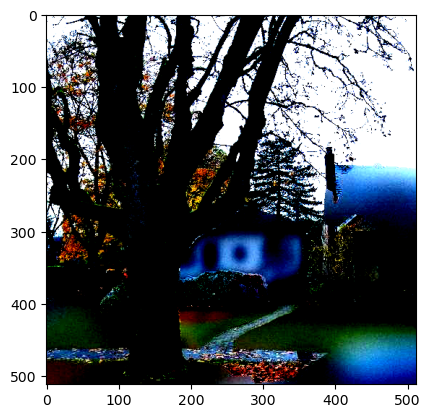

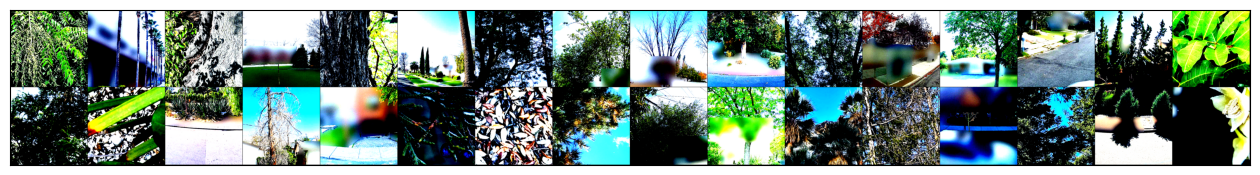

In [18]:
# How many classes are in the training and testing datasets?
print("Classes in the Training Dataset : /n", len(train_dataset.classes))
print("Classes in the Testing Dataset : /n", len(test_dataset.classes))
print("Classes in the Testing Dataset (Autoarborist Only) : /n", len(test_dataset_aa.classes))
print("Classes in the Testing Dataset (iNaturalist Only) : /n", len(test_dataset_inat.classes))

# Display the first image in the dataset
display_img(*train_dataset[2])

# Visualize a single batch of images
show_batch(train_dl)

#### Load data to GPU

In [19]:
# Get GPU Device
device = get_default_device()
device

# Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Load the model to the GPU
model = to_device(EfficientNetImageClassification(), device)

device(type='cuda')

EfficientNetImageClassification(
  (network): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           

#### Fit and Save Model & Model History - update paths

In [20]:
# Fit model and record result after epoch
# Model history contains training loss, validation loss, and validation accuracy metrics
history = fit(num_epochs, base_lr, model, train_dl, val_dl, opt_func)

# Save the model weights file to path
model_path = r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth"

# Torch.Save model to file: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)

#export the model history to a csv file
history_path = r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.csv"
history_df = pd.DataFrame(history)
#add column for epoch
history_df['epoch'] = history_df.index + 1
history_df.to_csv(history_path, index=False)

NameError: name 'amp' is not defined

#### Visualize model performance

##### Accuracy and loss curves

In [ ]:
plot_accuracies(history)


In [ ]:
plot_losses(history)

##### Load Pre-Trained Model and Setup for Model Evaluation

In [ ]:
# Load a pre-trained model
model_path = r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-aug-apr1124.pth"

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

##### Confusion Matrix: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_confusion_matrix_all.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_classification_report_all.csv")

##### Confusion Matrix: All Images (Autoarborist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_aa:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_confusion_matrix_aaonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_classification_report_aaonly.csv")

##### Confusion Matrix: All Images (iNaturalist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_inat:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_confusion_matrix_inatonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (iNaturalist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera)) 

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\exp3_randomcrop\exp3_classification_report_inatonly.csv")

### Experiment 4: The effect of a curated iNaturalist training set on CNN image classification performance.
The "curated" iNaturalist dataset was created by using the base model trained on AutoArborist data only was used to predict on all downloaded iNaturalist images. Per genus, we retained images with the top 1000 softmax probability predicted by this model.

Hypothesis: A curated iNaturalist training set will improve performance across genera when compared to the base model trained on AutoArborist only. The magnitude of change per genus will correspond to the magnitude of change between the median softmax score in the random iNaturalist data used in the base model trained on the combined data ("randomly" selected iNaturalist + AutoArborist)


#### Define Image Augumentations - Update paths

In [29]:
# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root
test_data_dir_aa = testing_destination_root_aa
test_data_dir_inat = testing_destination_root_inat

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(512, 512), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5046049, 0.5396771, 0.48857558), std=(0.21761383, 0.21475579, 0.24712493))
])

# Ensure images are resized during testing as same dimension for training
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(512, 512), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5046049, 0.5396771, 0.48857558), std=(0.21761383, 0.21475579, 0.24712493))
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)
test_dataset_aa = ImageFolder(test_data_dir_aa, transform = test_transforms)
test_dataset_inat = ImageFolder(test_data_dir_inat, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)

Dataset ImageFolder
    Number of datapoints: 44900
    Root location: D:\blaginh\tree_classification\aa_inat_combined\training_data_top1000_may724_curated
    StandardTransform
Transform: Compose(
                 ToImage()
                 RandomResizedCrop(size=(512, 512), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
                 Normalize(mean=[0.5046049, 0.5396771, 0.48857558], std=[0.21761383, 0.21475579, 0.24712493], inplace=False)
           )

torch.Size([3, 512, 512]) 0


#### Define training, validation, and testing data loaders

In [30]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation (typically, 10% of the training set)
val_size = 2000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 20000
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_aa = DataLoader(dataset = test_dataset_aa, batch_size = 1, num_workers = 4, pin_memory = True)
test_dl_inat = DataLoader(dataset = test_dataset_inat, batch_size = 1, num_workers = 4, pin_memory = True)

# Instantiate the model
model = EfficientNetImageClassification()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

Length of Train Data : 42900
Length of Validation Data : 2000
Number of Model Parameters:  20209513


#### Load to GPU

In [33]:
# Get GPU Device
device = get_default_device()
device

# Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Load the model to the GPU
model = to_device(EfficientNetImageClassification(), device)

device(type='cuda')

EfficientNetImageClassification(
  (network): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           

#### Fit and Save Model & Model History - update paths

In [34]:
# Fit model and record result after epoch
# Model history contains training loss, validation loss, and validation accuracy metrics
history = fit(num_epochs, base_lr, model, train_dl, val_dl, opt_func)

# Save the model weights file to path
model_path = r"D:\blaginh\tree_classification\model_outputs\exp4_curated_top1000\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-cur-may824.pth"

# Torch.Save model to file: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)

#export the model history to a csv file
history_path = r"D:\blaginh\tree_classification\model_outputs\exp4_curated_top1000\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-acur-apr824.csv"
history_df = pd.DataFrame(history)
#add column for epoch
history_df['epoch'] = history_df.index + 1
history_df.to_csv(history_path, index=False)

#### Visualize model performance

##### Load Pre-Trained Model and Setup for Model Evaluation

In [15]:
# Load a pre-trained model
model_path = r"D:\blaginh\tree_classification\model_outputs\exp4_curated_top1000\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-cur-march724.pth"

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

device(type='cuda')

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\blaginh\\tree_classification\\model_outputs\\exp4_curated_top1000\\tree-classification-autoarb_inat-25-genera-1000imgs-effnet2s-10epochs-lr001-cur-march724.pth'

##### Confusion Matrix: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\base\base_confusion_matrix_all.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist & iNaturalist) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\base\base_classification_report_all.csv")

##### Confusion Matrix: All Images (Autoarborist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_aa:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\base\base_confusion_matrix_aaonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (Autoarborist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\base\base_classification_report_aaonly.csv")

##### Confusion Matrix: All Images (iNaturalist Only) - update path

In [ ]:
# Model Evaluation with Confusion Matrix
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_dl_inat:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        output = torch.argmax(output, dim=1).cpu().numpy()  # Extract predicted labels directly
        y_pred.extend(output)
        
        labels = labels.cpu().numpy()
        y_true.extend(labels)

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=selected_genera)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.savefig(r"D:\blaginh\tree_classification\model_outputs\base\base_confusion_matrix_inatonly.png", dpi=200)
#plt.close()
plt.show()

##### Precision, recall, F1, support per class: All Images (iNaturalist only) - update path

In [ ]:
print(classification_report(y_true, y_pred, target_names = selected_genera))

# Export classification report to csv
report_data = classification_report(y_true, y_pred, target_names = selected_genera, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df.to_csv(r"D:\blaginh\tree_classification\model_outputs\base\base_classification_report_inatonly.csv")